Based on https://github.com/Lasagne/Lasagne/blob/highway_example/examples/Hidden%20factors.ipynb


In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

from tensorflow.contrib.layers import xavier_initializer


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
input_dim = 784 # MNIST data input (img shape: 28*28)
output_dim = 10 # MNIST total classes (0-9 digits)
latent_dim = 2
num_hidden_units=500


# variables
X = tf.placeholder(tf.float32, shape=[None, input_dim])
y_ = tf.placeholder(tf.float32, shape=[None, output_dim])

# encoder
with tf.variable_scope("encoder"):
    enc_W1 = tf.get_variable("W1", shape=[input_dim, num_hidden_units], initializer=xavier_initializer())
    enc_b1 = tf.get_variable("b1", shape=[num_hidden_units], initializer=tf.zeros_initializer())

    enc_W2 = tf.get_variable("W2", shape=[num_hidden_units, num_hidden_units], initializer=xavier_initializer())
    enc_b2 = tf.get_variable("b2", shape=[num_hidden_units], initializer=tf.zeros_initializer())

# learned representation
with tf.variable_scope("representation"):
    obs_W = tf.get_variable("W_obs", shape=[num_hidden_units, output_dim], initializer=xavier_initializer())
    obs_b = tf.get_variable("b_obs", shape=[output_dim], initializer=tf.zeros_initializer())

    lat_W = tf.get_variable("W_lat", shape=[num_hidden_units, latent_dim], initializer=xavier_initializer())
    lat_b = tf.get_variable("b_lat", shape=[latent_dim], initializer=tf.zeros_initializer())

# decoder
with tf.variable_scope("decoder"):
    dec_W1 = tf.get_variable("W1", shape=[latent_dim+output_dim, num_hidden_units], initializer=xavier_initializer())
    dec_b1 = tf.get_variable("b1", shape=[num_hidden_units], initializer=tf.zeros_initializer())

    dec_W2 = tf.get_variable("W2", shape=[num_hidden_units, num_hidden_units], initializer=xavier_initializer())
    dec_b2 = tf.get_variable("b2", shape=[num_hidden_units], initializer=tf.zeros_initializer())

# output
with tf.variable_scope("output"):
    out_W = tf.get_variable("W", shape=[num_hidden_units, input_dim], initializer=xavier_initializer())
    out_b = tf.get_variable("b", shape=[input_dim], initializer=tf.zeros_initializer())




In [6]:
# training model
# encoder
noise_factor = 0.05
l_encoder1 = tf.nn.relu(tf.matmul((X + tf.random_normal(shape=tf.shape(X), mean=0., stddev=noise_factor)),
                            enc_W1) + enc_b1) # layer with noise
l_encoder2 = tf.nn.relu(tf.matmul(l_encoder1, enc_W2) + enc_b2)

# learned representation
l_observed = tf.nn.softmax(tf.matmul(l_encoder2, obs_W) + obs_b)
l_latent = tf.matmul(l_encoder2, lat_W) + lat_b # linear

l_representation = tf.concat([l_latent, y_], 1)

# decoder
l_decoder1 = tf.nn.relu(tf.matmul(l_representation, dec_W1) + dec_b1)
l_decoder2 = tf.nn.relu(tf.matmul(l_decoder1, dec_W2) + dec_b2)

# reconstruction layer
l_decoder_out = tf.matmul(l_decoder2, out_W) + out_b

In [7]:
# cost
alpha=1.0
beta=10.0
gamma=10.0

# unsupervised cost: mean squared error
U = tf.reduce_mean(tf.square(l_decoder_out - X))

# supervised cost: categorical cross-entropy
S = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(l_observed),[1]))

# XCov cost: cross-covariance
y_pred_mean = tf.reduce_mean(l_observed, axis=0)
z_mean = tf.reduce_mean(l_latent, axis=0)
y_pred_centered = l_observed - y_pred_mean # (n, i)
z_centered = l_latent - z_mean # (n, j)

outer_prod =  tf.matmul(tf.expand_dims(y_pred_centered, 2), tf.expand_dims(z_centered, 1))  # (n, i, j)
C = 0.5 * tf.reduce_sum(tf.square(tf.reduce_mean(outer_prod, axis=0)))

cost = alpha * U + beta * S + gamma * C
#reg = tf.nn.l2_loss(enc_W1) \
#      + tf.nn.l2_loss(enc_W2) \
#      + tf.nn.l2_loss(obs_W) \
#      + tf.nn.l2_loss(lat_W) \
#      + tf.nn.l2_loss(dec_W1) \
#      + tf.nn.l2_loss(dec_W2) \
#      + tf.nn.l2_loss(out_W)

#l2_reg = 0.01
#cost += l2_reg * reg

In [8]:
# training
learning_rate = 1
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(cost)

display_step = 10
training_epochs = 20
batch_size = 100

# Initializing the variables
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([train_op, cost], feed_dict={X: batch_x,
                                                        y_: batch_y})
        # Compute average loss
        avg_cost += c / total_batch
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
print("Optimization Finished!")


Epoch: 0001 cost=2.919339431
Epoch: 0011 cost=0.169163549
Optimization Finished!


In [9]:
# testing model
# encoder
l_encoder1_test = tf.nn.relu(tf.matmul(X, enc_W1) + enc_b1)
l_encoder2_test = tf.nn.relu(tf.matmul(l_encoder1_test, enc_W2) + enc_b2)

# learned representation
l_observed_test = tf.nn.softmax(tf.matmul(l_encoder2_test, obs_W) + obs_b)
l_latent_test = tf.matmul(l_encoder2_test, lat_W) + lat_b # linear


given_z = tf.placeholder(tf.float32, shape=[None, 2])
given_y = tf.placeholder(tf.float32, shape=[None, output_dim])


l_representation_test = tf.concat([given_z, given_y], 1)

# decoder
l_decoder1_test = tf.nn.relu(tf.matmul(l_representation_test, dec_W1) + dec_b1)
l_decoder2_test = tf.nn.relu(tf.matmul(l_decoder1_test, dec_W2) + dec_b2)

# reconstruction layer
l_decoder_out_test = tf.matmul(l_decoder2_test, out_W) + out_b


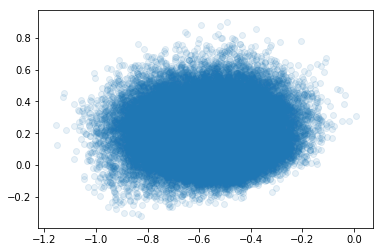

In [10]:
z_vals = np.empty((0,2), float)
# Loop over all batches
for i in range(total_batch):
    batch_x, batch_y = mnist.train.next_batch(batch_size)    
    batch_z = sess.run(l_latent_test, feed_dict={X: batch_x}) # TODO usar testing model
    z_vals = np.append(z_vals, batch_z, axis=0)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(z_vals[:, 0], z_vals[:, 1], alpha=0.1)
plt.show()


In [11]:
ys = np.repeat(np.arange(10), 9).astype('int32')
ys = sess.run(tf.one_hot(ys, output_dim))
zs = np.tile(np.linspace(-0.5, 0.5, 9), 10).astype("float32")
z1s = np.vstack([zs, np.zeros_like(zs)]).T
z2s = np.vstack([np.zeros_like(zs), zs]).T

In [12]:
reconstructions_z1 = sess.run(l_decoder_out_test, feed_dict={given_z:z1s, given_y:ys})
reconstructions_z2 = sess.run(l_decoder_out_test, feed_dict={given_z:z2s, given_y:ys})

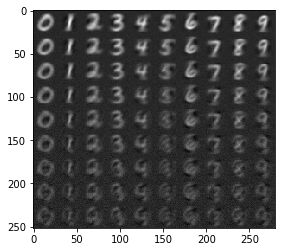

In [13]:
im1 = reconstructions_z1.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im1, cmap=plt.cm.gray)
plt.show()

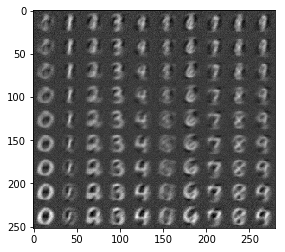

In [14]:
im2 = reconstructions_z2.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im2, cmap=plt.cm.gray)
plt.show()